## Notebook Setup

In [1]:
# IMPORT STATEMENTS
import h2o
from h2o.estimators.kmeans import H2OKMeansEstimator
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CONSTANT DECLARATIONS
IRIS_DATA_PATH = "http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv"

In [3]:
# MISC SETUP
sns.set_context("notebook")

### Initiating h2o instance

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.201-b09, mixed mode)
  Starting server from c:\programdata\miniconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\retim\AppData\Local\Temp\tmpe8sagan_
  JVM stdout: C:\Users\retim\AppData\Local\Temp\tmpe8sagan_\h2o_retim_started_from_python.out
  JVM stderr: C:\Users\retim\AppData\Local\Temp\tmpe8sagan_\h2o_retim_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,"21 days, 13 hours and 57 minutes"
H2O cluster name:,H2O_from_python_retim_1ehsic
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


## 1. Import the Iris dataset

In [5]:
#%%time
iris_df = h2o.import_file(IRIS_DATA_PATH)

Parse progress: |█████████████████████████████████████████████████████████| 100%


### Data EDA

In [6]:
iris_df.describe()

Rows:150
Cols:5




,sepal_len,sepal_wid,petal_len,petal_wid,class
type,real,real,real,real,enum
mins,4.3,2.0,1.0,0.1,
mean,5.843333333333333,3.053999999999999,3.758666666666667,1.1986666666666665,
maxs,7.9,4.4,6.9,2.5,
sigma,0.8280661279778637,0.43359431136217375,1.764420419952262,0.7631607417008414,
zeros,0,0,0,0,
missing,0,0,0,0,0
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [7]:
iris_df.head(5)

sepal_len,sepal_wid,petal_len,petal_wid,class
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
5,3.6,1.4,0.2,Iris-setosa


In [8]:
iris_df.tail(5)

sepal_len,sepal_wid,petal_len,petal_wid,class
6.7,3,5.2,2.3,Iris-virginica
6.3,2.5,5,1.9,Iris-virginica
6.5,3,5.2,2,Iris-virginica
6.2,3.4,5.4,2.3,Iris-virginica
5.9,3,5.1,1.8,Iris-virginica


Simple small dataset with no missing values, only simple numeric types for features 

## 2. Run a group_by on Species type, generating the mean of C1-C4 for each group.

In [9]:
# grouping by it class and count the group with its mean for each variable or columns
feature_means = iris_df.group_by("class").count().mean().get_frame()
feature_means # Save for later comparison with kmean centroids

class,nrow,mean_sepal_len,mean_sepal_wid,mean_petal_len,mean_petal_wid
Iris-setosa,50,5.006,3.418,1.464,0.244
Iris-versicolor,50,5.936,2.77,4.26,1.326
Iris-virginica,50,6.588,2.974,5.552,2.026


## visual display of the data frame, matrix plot for each variable compares to other 

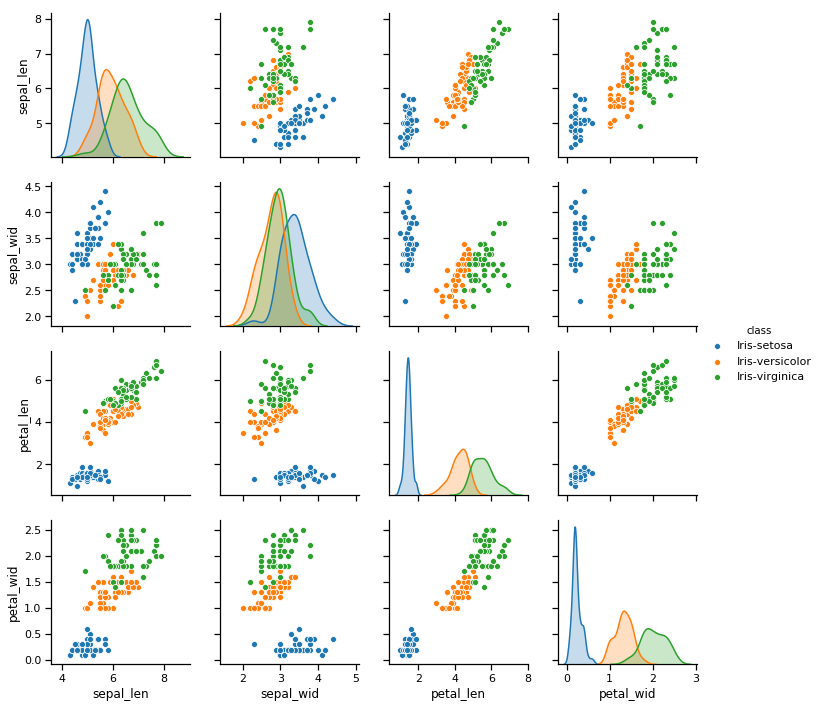

In [10]:
sns.pairplot(iris_df.as_data_frame(True), vars=iris_df.columns[:-1], hue = 'class');

## 3. Build a K-Means model with 3 centroids

In [11]:
# Distinguish features from target
predictors = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']
target = 'class'

# Ensure target is properly typed
iris_df[target] = iris_df[target].asfactor()

# Train/valid/test split and unpack - random seed for reproducibility
train, valid = iris_df.split_frame(ratios=[0.8], seed=1234)
print("Train Size: {}\nValidate Size: {}\n".format(*(train.shape[0], valid.shape[0])))

Train Size: 123
Validate Size: 27



In [12]:
# estimator instantiation
iris_kmeans_est = H2OKMeansEstimator(k=3, 
                                    estimate_k= True, 
                                    standardize = False, 
                                    seed =1234)
#fit model on train set
iris_kmeans_est.train(x = predictors,
                      y = target, 
                      training_frame = train, 
                      validation_frame = valid)

kmeans Model Build progress: |████████████████████████████████████████████| 100%


In [13]:
clusters = 4
predicted = iris_df.cbind(iris_kmeans_est.predict(iris_df))

kmeans prediction progress: |█████████████████████████████████████████████| 100%


In [14]:
predicted.head(5)

sepal_len,sepal_wid,petal_len,petal_wid,class,predict
5.1,3.5,1.4,0.2,Iris-setosa,0
4.9,3,1.4,0.2,Iris-setosa,0
4.7,3.2,1.3,0.2,Iris-setosa,0
4.6,3.1,1.5,0.2,Iris-setosa,0
5,3.6,1.4,0.2,Iris-setosa,0


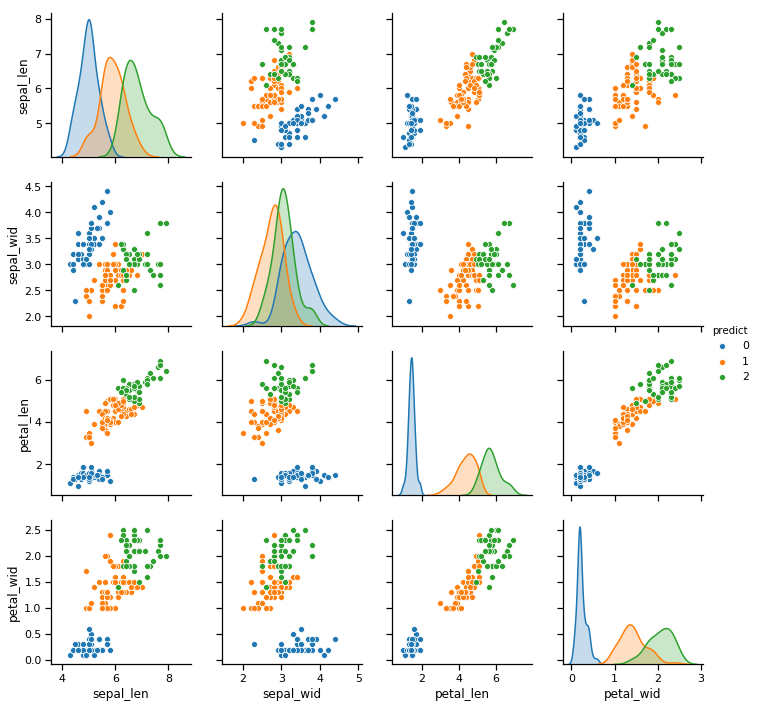

In [15]:
sns.pairplot(predicted.as_data_frame(True), vars=predicted.columns[:-2], hue = 'predict');

In [16]:
# Fitted model details
iris_kmeans_est

Model Details
H2OKMeansEstimator :  K-means
Model Key:  KMeans_model_python_1555961766706_1


ModelMetricsClustering: kmeans
** Reported on train data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 63.09516069071749
Total Sum of Square Error to Grand Mean: 546.9092331233204
Between Cluster Sum of Square Error: 483.8140724326029
Centroid Statistics: 


,centroid,size,within_cluster_sum_of_squares
,1.0,36.0,11.0874995
,2.0,51.0,30.7862745
,3.0,36.0,21.2213867



ModelMetricsClustering: kmeans
** Reported on validation data. **

MSE: NaN
RMSE: NaN
Total Within Cluster Sum of Square Error: 16.113235645199744
Total Sum of Square Error to Grand Mean: 102.0614794874288
Between Cluster Sum of Square Error: 85.94824384222906
Centroid Statistics: 


,centroid,size,within_cluster_sum_of_squares
,1.0,14.0,4.2104167
,2.0,11.0,9.2084512
,3.0,2.0,2.6943677


Scoring History: 


,timestamp,duration,iterations,number_of_clusters,number_of_reassigned_observations,within_cluster_sum_of_squares
,2019-04-22 13:36:17,0.010 sec,0.0,0.0,nan,nan
,2019-04-22 13:36:17,0.034 sec,1.0,1.0,123.0,641.7600000
,2019-04-22 13:36:17,0.040 sec,2.0,1.0,0.0,546.9092683
,2019-04-22 13:36:17,0.049 sec,3.0,2.0,6.0,131.0961516
,2019-04-22 13:36:17,0.049 sec,4.0,2.0,0.0,125.1354644
,2019-04-22 13:36:17,0.055 sec,5.0,3.0,8.0,64.4767478
,2019-04-22 13:36:17,0.056 sec,6.0,3.0,1.0,63.1665734
,2019-04-22 13:36:17,0.056 sec,7.0,3.0,0.0,63.0951634


## Quick Error Rate Examination

In [17]:
def error_rate(model, predict_df):
    """
    calculates the rate on the given dataframe to predict by the model
    Input
        model: model to be evaluated on
        predict: data frame that model is predicting, either valid, test or train
                has to be in same varibles as the training frame of the model 
    Output
        error rate on the prediction by the model
    
    """
    predicted_df = predict_df.cbind(model.predict(predict_df)).as_data_frame()
    error_frame = predicted_df[((predicted_df['class']=='Iris-setosa')&(predicted_df['predict']!= 0))|
                               ((predicted_df['class']=='Iris-versicolor')&(predicted_df['predict']!= 1))|
                              ((predicted_df['class']=='Iris-virginica')&(predicted_df['predict']!= 2))]
    return (error_frame.shape[0])/(predict_df.shape[0])

In [18]:
"Train Set Error: {:0.2f}% Incorrect".format(error_rate(iris_kmeans_est, train))

kmeans prediction progress: |█████████████████████████████████████████████| 100%


'Train Set Error: 0.12% Incorrect'

In [19]:
"Validation Set Error: {:0.2f}% Incorrect".format(error_rate(iris_kmeans_est, valid))

kmeans prediction progress: |█████████████████████████████████████████████| 100%


'Validation Set Error: 0.04% Incorrect'

Small Dataset size likely responsible for odd error rates

## 8. Centroids vs Feature Means Comparison

In [20]:
# feature_means = feature_means.as_data_frame()
# feature_means

In [21]:
centroids = pd.DataFrame(data=iris_kmeans_est.centers(), columns=predictors)
centroids

,sepal_len,sepal_wid,petal_len,petal_wid
0,4.983333,3.394444,1.455556,0.247222
1,5.943137,2.749020,4.421569,1.450980
2,6.830556,3.050000,5.741667,2.075000


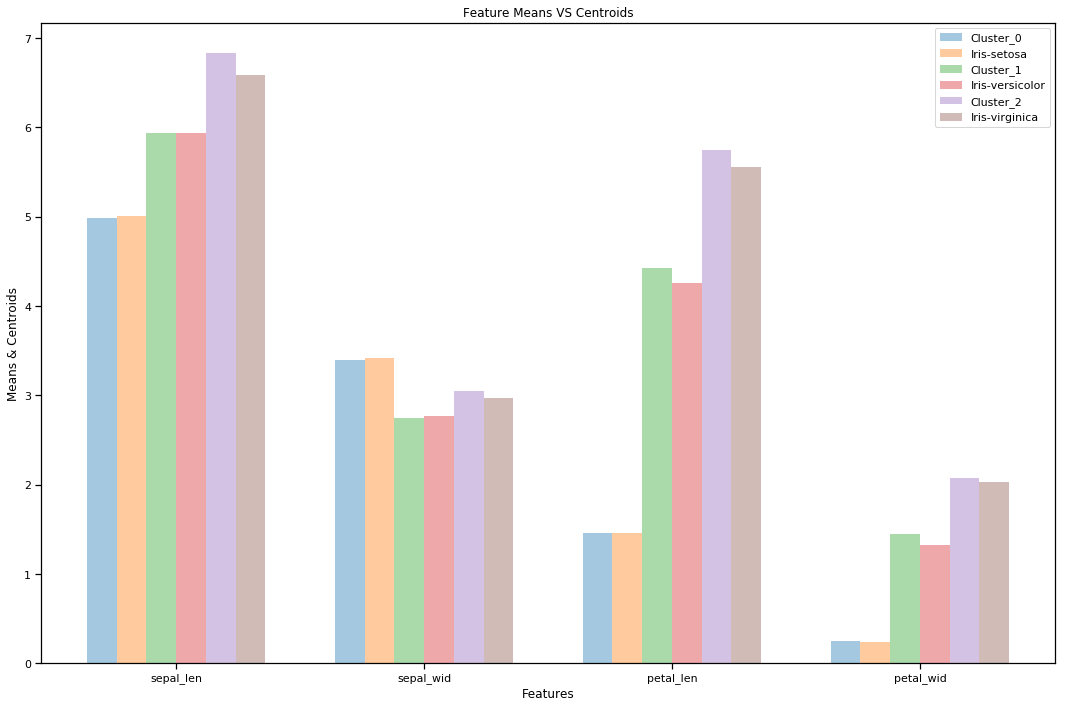

In [22]:
n_groups = centroids.shape[1]
feature_names = list(centroids.columns)
centroid_nums = list(centroids.index)
feature_means = feature_means.as_data_frame()

fig, ax = plt.subplots(figsize=(15, 10))
index = np.arange(n_groups)
bar_width = 0.12

opacity = 0.4
error_config = {'ecolor': '0.3'}

# Create All Bar Groups for centroids
for ind, centroid_num in enumerate(centroid_nums):
    heights = centroids.iloc[centroid_num].tolist()
    label = f"Cluster_{centroid_num}"

    loc = index + ((ind + ind) * bar_width)
    ax.bar(loc, heights, bar_width, alpha=opacity, label=label)
    
    heights = feature_means[['mean_sepal_len', 'mean_sepal_wid', 'mean_petal_len', 'mean_petal_wid']].iloc[ind].values
    label = feature_means[['class']].iloc[ind][0]
    
    loc = index + ((ind + (ind + 1)) * bar_width)
    ax.bar(loc, heights, bar_width, alpha=opacity, 
           #yerr=std_men, error_kw=error_config, 
           label=label) 
    
ax.set_xlabel('Features')
ax.set_ylabel('Means & Centroids')
ax.set_title('Feature Means VS Centroids')
ax.set_xticks((index + bar_width / 2) + 2 * bar_width)
ax.set_xticklabels(feature_names)
ax.legend()

fig.tight_layout()
plt.show()

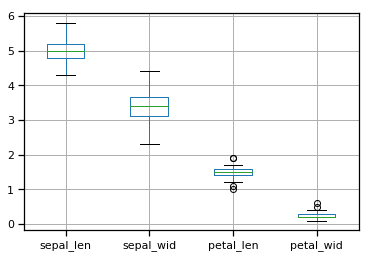

In [23]:
iris_df[iris_df['class']=="Iris-setosa"].as_data_frame().boxplot()
plt.show()

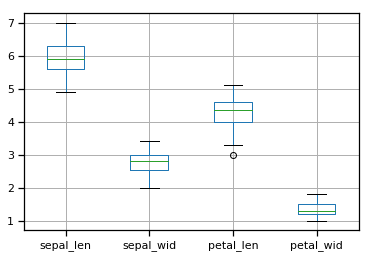

In [24]:
iris_df[iris_df['class']=="Iris-versicolor"].as_data_frame().boxplot()

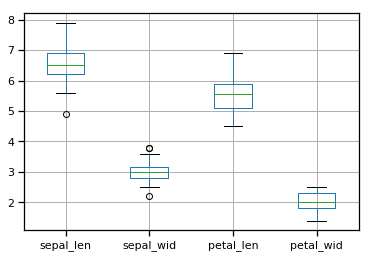

In [25]:
iris_df[iris_df['class']=="Iris-virginica"].as_data_frame().boxplot()

In the K-means clustering algorithm "means" refers to averaging of all the data point and to find the centroid and allocating each data point  <br>
to the centroid closest to the data point while keeping the number of centroids as small as possible, each variable on each plan of dimensions <br>
which is equal to number of the variable/predictors. Hence, the arithmetic mean of for each class and its variable are same as the cluster <br>
centroids for this case as seen above, and difference are very small and negligible. 


In [ ]:
#h2o.shutdown()